In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import classification_report, confusion_matrix
from logreg import LogReg

np.set_printoptions(precision=4, suppress=True)

# Logistic regression

The example considers the Skin-NonSkin dataset of Bhatt and Dhall. It consists of 245,057 samples of which 50,859 are skin samples and 194,198 are non-skin samples. The dataset was collected by randomly sampling RGB values from face images of various age groups (young, middle, and old), race groups (white, black, and Asian), and gender. The samples were obtained from the FERET and PAL databases. Each data item consists of four variables -- B, G, R and the class label.

Three randomly chosen rows:

    ---
    B, G, R, Class
    242, 169, 161,   2
    218, 211, 202,   2
    110, 150, 209,   1
    ---
    
**We will use the regressor $x_t = [1, B_t, G_t, R_t]$, normal prior $\mathcal{N}$(**_0_**, 100**_I_**) and the threshold _m_=0.5.**

First, we load data. As they are ordered, we need to shuffle them.

In [2]:
np.random.seed(1234)
ndat = 5000

fn = 'Skin_NonSkin.txt'
data = np.loadtxt(fn)
np.random.shuffle(data)
data = data[:ndat]

print("First three rows:")
print(data[:3])

First three rows:
[[242. 169. 161.   2.]
 [218. 211. 202.   2.]
 [110. 150. 209.   1.]]


Note the classes are 1 a 2 (Skin a NonSkin), so we need to subtract 1.

**Task: Prepare regressors (X) and measurements (y).**

In [3]:
data[:,3] -= 1
X = np.c_[np.ones((data.shape[0], 1)), data[:, :3]]
y = data[:, 3]

print("First three regressors:\n", X[:3])
print("\nFirst three measurements:\n", y[:3])

First three regressors:
 [[  1. 242. 169. 161.]
 [  1. 218. 211. 202.]
 [  1. 110. 150. 209.]]

First three measurements:
 [1. 1. 0.]


We start with the prior $\mathcal{N}([0, 0, 0, 0], 100I_{4\times 4}).$

In [4]:
#%% Prior
mean = np.zeros(X.shape[-1])
Sigma = np.eye(X.shape[-1]) * 100.
prior = LogReg(mean=mean, Sigma=Sigma)

Estimation: we update by one regressor and one measurements sequentially (Skin-NonSkin)

In [5]:
#%% Estimation
for xt, yt in zip(X, y):
    prior.update(yt, xt)
    prior.log()  

Let us see the Brier score evolution.

Text(0, 0.5, 'Brier score')

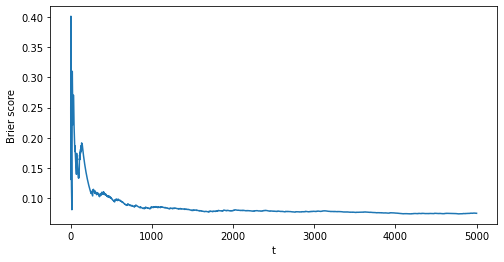

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(prior.brier_score_log)
plt.xlabel('t')
plt.ylabel('Brier score')

Raw data and binary predictions can be found in the attributes `logreg.true_vals` and `logreg.binary_preds`. Both are lists.

In [7]:
cm = confusion_matrix(y_true=prior.true_vals, 
                      y_pred=prior.binary_preds)
print(cm)

[[ 870  205]
 [ 237 3688]]


The classification report shows [precision, recall, and other statistics](https://en.wikipedia.org/wiki/Precision_and_recall):

In [8]:
report = classification_report(y_true=prior.true_vals, 
                               y_pred=prior.binary_preds)
print(report)

              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80      1075
         1.0       0.95      0.94      0.94      3925

    accuracy                           0.91      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.91      0.91      0.91      5000



Finally, we can compare the Bayesian point estimates with the MLE one-shot ones:

In [9]:
from statsmodels.discrete.discrete_model import Logit
MLE = Logit(endog=y, exog=X).fit()
MLE.summary()

Optimization terminated successfully.
         Current function value: 0.252005
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4996
Method:                           MLE   Df Model:                            3
Date:                Fri, 18 Feb 2022   Pseudo R-squ.:                  0.5158
Time:                        11:52:28   Log-Likelihood:                -1260.0
converged:                       True   LL-Null:                       -2602.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2672      0.188     22.739      0.000       3.899       4.635
x1             0.0251      0.002     13.511      0.000       0.021       0.029
x2            -0.0056      0.002     -2.493      0.013      -0.010      -0.001
x3            -0.0348      0.001    -31.592      0.000      -0.037      -0.033
==============================================================================
"""

In [10]:
print(f'Bayes\t: {prior.mean}')
print(f'MLE\t: {MLE.params}')

Bayes	: [ 4.1873  0.0234 -0.0041 -0.0342]
MLE	: [ 4.2672  0.0251 -0.0056 -0.0348]
